# Project Title

## Import

In [1]:
# Install required packages
%pip install -qU bs4
%pip install -qU chromadb
%pip install -qU tiktoken
%pip install -qU langchain
%pip install -qU langgraph
%pip install -qU langchainhub
%pip install -qU tavily-python
%pip install -qU "nomic[local]"
%pip install -qU langchain-nomic
%pip install -qU langchain-ollama
%pip install -qU langchain_community


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import
import os
import getpass
import operator
import requests

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import Annotated, List, Literal

# from langchain import hub
from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph

import warnings
warnings.filterwarnings("ignore")


In [10]:
## Constants

# The base URL and the webpage to crawl
ITA_HOMEPAGE_URL = "https://www.italia.it/en"       # WebPage for Data extraction 
EN_BASE_URL = "https://www.italia.it/en"   # Base URL address for crawling internal URLs 

# # Regions List for URLs
# REGIONS = ["abbruzzo", "aosta-valley", "puglia", "basilicata", "calabria", "campania", "emilia-romagna", "friuli-venezia-giulia", "lazio", "liguria", "lombardy", "marche", "piedmont", "sardinia", "trentino", "south-tyrol", "tuscany", "umbria", "veneto"] 


## Setup

In [4]:
# Setup environment 
def _set_env(key: str) -> None:
    """
    Set the environment variables.
        Args:
            key (str): The name of the environment variable.
    """
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter {key}:")

# _set_env("LANGCHAIN_API_KEY")
_set_env("NOMIC_API_KEY")
_set_env("TAVILY_API_KEY")

# LangChain key: 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
# Nomic key: nk-2lWlK26_eyFeHHN8bAA4tiIaqEJNjJ8vCGkIlnBiz1M
# Tavily key: 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


In [42]:
# LLM 
local_llm = "llama3.2"  
llm = ChatOllama(model=local_llm, temperature=0)

# Initialize Tavily to retrieve the top 3 web search results
tavily_web_search = TavilySearchResults(max_results=3)


In [175]:
# retrieve internal links from a webpage 
def get_internal_links(website_url, base_url):
    """
        Retrieves internal links from the given webpage URL that start with the base URL.
    
        Args:
        - website_url (str): The URL of the webpage to crawl.
        - base_url (str): The base URL to filter internal links (e.g., "https://www.italia.it/en").
    
        Returns:
        - list[str]: A list of internal URLs that begin with the base URL.
    """
    # Send a request to the website
    response = requests.get(website_url)
    
    # Parse the content of the webpage
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Set of internal links
    internal_links = set()
    
    # Find all <a> tags with href attributes
    for link in soup.find_all("a", href=True):
        # Convert relative URLs to absolute URLs
        href = urljoin(base_url, link["href"])
        
        # Check if the URL starts with the base URL
        if href.startswith(base_url):
            internal_links.add(href)
    
    return list(internal_links)

# The base URL and the webpage to crawl
italian_url = "https://www.italia.it/en"
en_base_address = "https://www.italia.it/en"

# # List to store internal URLs from all regions
# all_internal_urls = []
# 
# # Craw internal URLs
# for region in REGIONS:
#     # Dynamically create the base URL for each region
#     base_url = f"{italian_url}/{region}"
#     
#     # Get internal URLs for the specific region
#     internal_urls = get_internal_links(base_url, base_url)
#     
#     # Add the retrieved URLs to the overall list
#     all_internal_urls.extend(internal_urls)
# 
# counter = 0
# # Print all internal URLs from all regions
# for internal_url in all_internal_urls:
#     counter += 1
#     print(internal_url)
# 
# print(f"Counter: {counter}")

# Get the internal URLs
urls = get_internal_links(website_url=italian_url, base_url=en_base_address)

# Print the list of internal URLs
for url in urls:
    print(url)


https://www.italia.it/en/italy/things-to-do/art-culture/unesco-world-heritage-sites-italy
https://www.italia.it/en/login
https://www.italia.it/en/italy/things-to-do/small-towns-in-italy-by-the-sea
https://www.italia.it/en/basilicata/things-to-do/outdoors-basilicata
https://www.italia.it/en/italy/things-to-do/relax-and-wellness
https://www.italia.it/en/sicily/catania/things-to-do/event-ottobrata-zafferanese
https://www.italia.it/en/italy/things-to-do/luxury-experiences-and-destinations
https://www.italia.it/en/sicily/things-to-do/castelmola
https://www.italia.it/en/italy/things-to-do/nature/countryside-hills
https://www.italia.it/en/italy/seasons/summer
https://www.italia.it/en/italy/things-to-do/spirituality
https://www.italia.it/en/friuli-venezia-giulia
https://www.italia.it/en/south-tyrol/bolzano/things-to-do/event-maratona-di-bolzano
https://www.italia.it/en/italy/practical-information/money-payments-and-tipping-in-italy
https://www.italia.it/en/italy/beach-destinations
https://www.

## Vectorstore

In [ ]:
# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Set embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

# Add to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embeddings)

# Create retriever
retriever = vectorstore.as_retriever(k=3)


In [207]:
# Test retriever
retriever.invoke("Duomo")


[Document(metadata={'description': 'From The Last Supper to Milan Cathedral, discover the things to see and do in Milan. Visit the city of fashion and design.', 'language': 'en', 'source': 'https://www.italia.it/en/lombardy/milan', 'title': 'Milan: Things to do & Attractions to visit - Italia.it'}, page_content='The most famous and important square in Milan\nIt is impossible to travel to Milan and not pass through Piazza Duomo, the central square of the city. With its square shape, it is one of the largest in Italy, and an ideal place to start a tour. It is towered over by the Duomo, "Domm" in Milanese, the Gothic style cathedral with spires that is the icon of the Lombardy’s capital. A visit to the Duomo Museum, housed in the halls of the Royal Palace, is recommended. At the center of the square is the monument dedicated to Vittorio Emanuele II, an equestrian statue in bronze, representing the King intent on rein in his horse.\nA stop at the Galleria Vittorio Emanuele II with its larg

### Router

In [178]:
## Router
class QueryRoute(BaseModel):
    """
      Route a user query to the most relevant datasource.
    """
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM
structured_llm_router = llm.with_structured_output(QueryRoute)

# System prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to some famous italian city, touristic and historical places, food and travel tips for tourists.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Combine the system message and user question in a prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_instructions),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router


In [179]:
## Test router
print(question_router.invoke({"question": "Where is the Colosseum?"})) # expected result: vectorstore

print(question_router.invoke({"question": "What is the capital of France?"})) # expected result: web_search

datasource='vectorstore'
datasource='web_search'


### Relevance

In [180]:
# Retrieval Grader
class GradeDocs(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM
structured_llm_retrieval = llm.with_structured_output(GradeDocs)

# Prompt
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.  
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", doc_grader_instructions),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_retrieval


In [181]:
## Test grader
question_1 = "Where is the Colosseum located?"  # First question: expected score = yes
relevant_document_1 = retriever.get_relevant_documents(question_1)
docs_text_1 = relevant_document_1[1].page_content
print(retrieval_grader.invoke({"question": question_1, "document": docs_text_1}))

question_2 = "Who won the olympics 2024?"   # Second question: expected score = no
relevant_document_2 = retriever.get_relevant_documents(question_2)
docs_text_2 = relevant_document_2[1].page_content
print(retrieval_grader.invoke({"question": question_2, "document": docs_text_2}))


binary_score='yes'
binary_score='no'


In [119]:
# ## Generate
# 
# # Prompt 
# rag_prompt = hub.pull("rlm/rag-prompt")
# # rag_prompt.pretty_print()
# 
# # Post-processing
# def format_docs(documents):
#     return "\n\n".join(doc.page_content for doc in documents)
# 
# # Chain
# rag_chain = rag_prompt | llm | StrOutputParser()


In [ ]:
# # Generator execution example
# generate_answer = rag_chain.invoke({"context": relevant_document_1, "question": "Where is the fountain of Trevi?"})
# print(generate_answer)


### Planning

In [182]:
## Planning

# Prompt
planner_instructions = """
You are an expert travel planner with a kind and friendly personality. Always start the conversation by saying hello. You're excited to help travelers plan their perfect vacation with engaging and heartfelt recommendations. Present the information as if you are talking to a friend, making sure to be warm, conversational, and enthusiastic about the places to visit, the local cuisine, and tips for the trip. Make it feel like a personal guide. Don't be concise, but be conversational.

Question: {question}
Context: {context}

Plan:
- **Places to Visit**: 
    Start by warmly describing the main attractions, what makes them special, and why they're must-sees. Use friendly language like "You’ll love visiting..." or "Make sure to check out..."
    
- **Local Cuisine**: 
    Describe the local dishes with enthusiasm, like you're sharing a favorite meal with a friend. Phrases like "You can't leave without trying..." or "One bite of this and you'll see why it's a local favorite..." will make it feel personal.

- **Tips for Travelers**: 
    Offer helpful advice as if you're giving insider knowledge, with kind reminders like "Don’t forget to bring..." or "It's always good to know that..."

End with a friendly closing note like: "I hope you have an amazing time! Safe travels!"
"""

planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", planner_instructions),
        ("human", "User question: \n\n {question}"),
    ]
)
plan_chain = planner_prompt | llm | StrOutputParser()


In [138]:
# Test planner
planner_question = "What kind of places can I visit in Rome?"
relevant_docs = retriever.get_relevant_documents(planner_question)
generated_plan = plan_chain.invoke({"context": relevant_docs, "question": planner_question})
print(generated_plan)


Rome, the Eternal City, is a treasure trove of history, architecture, art, and culture. There are countless amazing places to visit in Rome, but here are some of the top attractions:

**Historical Landmarks**

1. Colosseum (Il Colosseo): This ancient amphitheater is one of Rome's most iconic landmarks and a must-visit.
2. Roman Forum (Foro Romano): Explore the ancient heart of Rome, featuring ruins of temples, basilicas, and markets.
3. Pantheon (Pantheon di Roma): Admire this magnificently preserved ancient temple with an impressive dome.

**Vatican City**

1. Vatican Museums (Musei Vaticani): Discover art and history from the Vatican's vast collections, including works by Michelangelo and Raphael.
2. Sistine Chapel (Capella Sistina): Marvel at Michelangelo's famous ceiling paintings in this iconic chapel.
3. St. Peter's Basilica (Basilica di San Pietro): The largest Christian church in the world, featuring stunning architecture and art.

**Other Attractions**

1. Trevi Fountain (Font

### Check for hallucination

In [213]:
# Hallucination Grader
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
    
# LLM
structured_llm_hallucination = llm.with_structured_output(GradeHallucinations)

# Prompt
hallucination_grader_instructions = """
You are a grader assessing whether the travel planner is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_instructions),
        ("human", "Set of facts: \n\n {documents} \n\n Plan: {planner}"),
    ]
)
hallucination_grader = hallucination_grader_prompt | structured_llm_hallucination


In [215]:
# Test hallucination grader
hallucination = hallucination_grader.invoke({"documents": relevant_docs[1].page_content, "planner": generated_plan})
print(hallucination)


binary_score='yes'


In [216]:
for doc in relevant_docs:
    hallucination = hallucination_grader.invoke({"documents": doc.page_content, "planner": generated_plan})
    print(hallucination.binary_score)

yes
yes
yes
yes
no
yes
no
no
yes
no


### Answer evaluation

In [187]:
# Answer Grader
class GradeAnswers(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    
# LLM
structured_llm_grader = llm.with_structured_output(GradeAnswers)

# Prompt
answer_grader_instructions = """You are a grader assessing whether the planner addresses / resolves a request \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the request."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_instructions),
        ("human", "User question: \n\n {question} \n\n Plan: {planner}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader


In [75]:
# Test answer grader
answer_grader.invoke({"question": planner_question, "planner": generated_plan})


GradeAnswers(binary_score='yes')

### Re-write query

In [188]:
# Prompt
re_write_instructions = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_instructions),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [189]:
# Test question re-writer 
question_rewriter.invoke({"question": planner_question})


'Improved Question:\n"What are some popular tourist attractions, landmarks, or neighborhoods to explore in Rome?"\n\nReasoning:\n\n* The original question is quite broad and open-ended, which may lead to a wide range of irrelevant results.\n* By adding "popular" and "tourist attractions", we\'re narrowing down the scope to well-known and frequently visited places in Rome.\n* Adding "landmarks" provides more specificity, as it implies iconic structures or monuments that are often associated with Rome\'s history and culture.\n* Finally, "neighborhoods" suggests a desire to explore local areas, which could lead to recommendations for residential districts, shopping areas, or other community-focused destinations.\n\nThis revised question is more targeted and specific, making it easier for the vector store retrieval system to provide relevant results.'

# Tavily: web search tool

In [190]:
# Test Tavily 
tavily_web_search.invoke({"query": "What is the typical dessert of the city of Treviso?"})


[{'url': 'https://www.accademiadeltiramisu.com/en/tiramisu-from-treviso-italys-patriotic-dessert/',
  'content': 'Tiramisù, a typical dessert from Treviso, was the first dessert to have patriotic ingredients. Looking at these ingredients, and at the historic period and the development of the recipe, it is easy to understand many aspects of the Treviso origins of this dessert. Lo scrittore Giovanni Comisso (1895 - 1969) In the 19th century, during the'},
 {'url': 'https://www.visititaly.eu/food-and-flavours/treviso-tiramisu-taste-and-tradition',
  'content': "The pride of Treviso Tiramisù's gastronomic offerings is the traditional recipe that, from the tables of the city of Treviso, ... Instead, head to the first floor if, in addition to Tiramisù and typical desserts, you want to savor classic local recipes revisited in a modern and creative way."},
 {'url': 'https://www.italyheritage.com/learn-italian/recipes/tiramisu.htm',
  'content': 'Here is an interview with Roberto Linguanotto, a

## Graph: Nodes & Edges

In [146]:
# Graph's state
class State(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        documents: list of documents.
        max_retries: the maximum number of hallucination checks permitted.
        loop_step: Indicates the current step in a looping process.
        planner: LLM planning.
        question: question.
        web_search: run web search
    """
    documents: List[str]
    max_retries: int
    loop_step: Annotated[int, operator.add]
    planner: str
    question: str
    web_search: str
    

In [217]:
# Node: retrieve documents
def retrieve(state: State):
    """
        Retrieve documents from vectorstore
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}


# Node: docs are relevant or not
def grade_documents(state: State):
    """
        Determines whether the retrieved documents are relevant to the question.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]    
    documents = state["documents"] 

    relevant_documents = []  # Score each doc
    select_web= "No"         # web_search tag 
    
    for d in documents:
        retrieval_score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        retrieval_grade = retrieval_score.binary_score
        
        if retrieval_grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            relevant_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # set a flag to indicate that we want to run web search
            select_web = "Yes"
            continue
            
    return {"documents": relevant_documents, "web_search": select_web}


# Node: make query great again
def transform_query(state: State):
    """
        Transform the query to produce a better question.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"question": better_question}


# Node: planning
def planner(state: State):
    """
        Generates a plan based on the provided query.
        
        Args:
            state (dict): The current graph state.
    
        Returns:
            state (dict): Updates planner key with the generated plan and
                the loop step, incremented by 1.
    """
    print("---PLANNER---")
    question = state["question"]            # get question state
    documents = state["documents"]          # get documents state
    loop_step = state.get("loop_step", 0)   # Init loop_step 
    
    # RAG planning
    make_plan = plan_chain.invoke({"context": documents, "question": question})
    
    return {"planner": make_plan, "loop_step": loop_step + 1}


# Node: search on the web
def web_search(state: State):
    """
    Web search based on the query.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]          
    documents = state.get("documents", []) 

    # Perform a web search using the Tavily
    web_docs = tavily_web_search.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}
    

In [239]:
# Edge: RAG or web
def route_question(state: State):
    """
        Route question to web search or RAG.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    if source.datasource == "web_search": 
        print("---ROUTE QUESTION TO WEB SEARCH---")
        
        return "websearch"
    
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        
        return "vectorstore"
    

# Edge: planner or web_search
def decide_to_plan(state: State):
    """
    Determines whether start planning, or search answer on the web.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    websearch = state["web_search"]
    filtered_documents = state["documents"]

    if websearch == "yes":  # Go to web
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:   # The docs are relevant
        print("---DECISION: PLANNER---")
        return "travel_planner"


# Edge: fact checking on docs
def grade_generation_v_documents_and_question(state: State):
    """
    Determines whether the planning is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    max_retries = state.get("max_retries", 3)
    plan = state["planner"]
    question = state["question"]
    
    hallucination_score = hallucination_grader.invoke(
        {"documents": documents, "planner": plan}
    )
    hallucination_grade = hallucination_score.binary_score

    # Check hallucination
    if hallucination_grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        answer_score = answer_grader.invoke({"question": question, "planner": plan})
        answer_grade = answer_score.binary_score
        
        if answer_grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print(f"---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "check"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"


### Build the graph

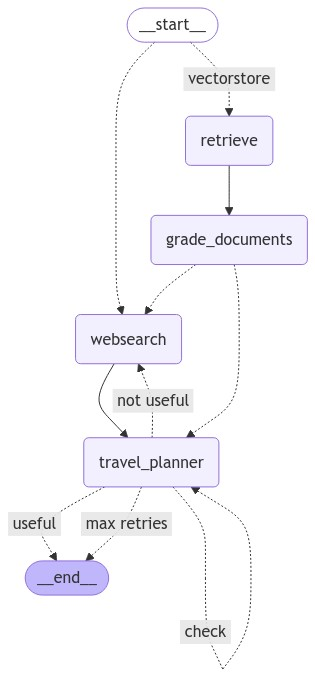

In [242]:
# Graph's state
workflow = StateGraph(State)

# Define the nodes
workflow.add_node(node="retrieve", action=retrieve)                 # retrieve
workflow.add_node(node="grade_documents", action=grade_documents)   # grade_documents
workflow.add_node(node="websearch", action=web_search)              # web_search
workflow.add_node(node="travel_planner", action=planner)            # travel_planner

# Build graph: edges and condition
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "travel_planner")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_plan,
    {
        "websearch": "websearch",
        "travel_planner": "travel_planner",
    },
)

workflow.add_conditional_edges(
    "travel_planner",
    grade_generation_v_documents_and_question,
    {
        "check": "travel_planner",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [240]:
# Test Graph
answer = graph.invoke({"question": "What kind of food can I eat while in Florence?"})["planner"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: PLANNER---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY (not supported in docs)---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY (not supported in docs)---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---
Hello! Oh, I'm so excited to talk about the food in Florence - it's truly one of my favorite parts of traveling there!

You'll love visiting Florence, and the food is a huge part of that experience. The city is known for its incredible Tuscan cuisine, which is all about fresh ingredients, simple preparation methods, and hearty portions.

One dish you absolutely can't leave with

In [227]:
# Test Graph
answer = graph.invoke({"question":"Where I can find the fountain of Trevi?"})["planner"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: PLANNER---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Hello! I'm so excited to help you plan your trip!

You're looking for the famous Fountain of Trevi, and I just know you'll love it when you see it in person. This stunning baroque fountain is one of Rome's most iconic landmarks, and it's a must-see when visiting the Eternal City.

The Fountain of Trevi is located in the heart of Rome, in the beautiful Piazza di Trevi. To get there, simply head to the city center and make your way to Via dei Condotti, which runs through the historic center. From there, follow the signs to Piazza

In [241]:
# Test Graph: expected generation grounded in docs
answer = graph.invoke({"question":"Where I need to go while in Aosta-valley?"})["planner"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: PLANNER---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY (not supported in docs)---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY (not supported in docs)---
---PLANNER---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---
Hello! I'm so excited to help you plan your trip to Aosta Valley!

Aosta Valley is a stunning region in the northwest of Italy, nestled in the heart of the Alps. It's a paradise for outdoor enthusiasts and foodies alike. Let me tell you about some of the must-see places you shouldn't miss while you're there.

First up, we have the breathtaking **Valle d'Aosta** itself! This val

In [ ]:
# Test Graph: expected generation NOT grounded in docs
answer = graph.invoke({"question":"What kind of food I can eat while visiting Paris?"})["planner"]
print(answer)


## 